# Analysis

In this section, we visualize and further clean our data, add features, and train a prediction model that attempts to accurately predict the number of likes an Instagram post will receive.

## Data Cleaning
Here, we visualize our scraped data and see how we can improve it before training our prediction model.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import r2_score, mean_squared_error
sns.set(style="whitegrid")

First, let's read in the data. We begin with 47737 posts from 356 users.

In [8]:
df = pd.read_json('../data/new/data.json')

Now, let's construct two key visualizations to help us detect outliers. We'll plot distributions for number of posts (by user) and number of likes per post.

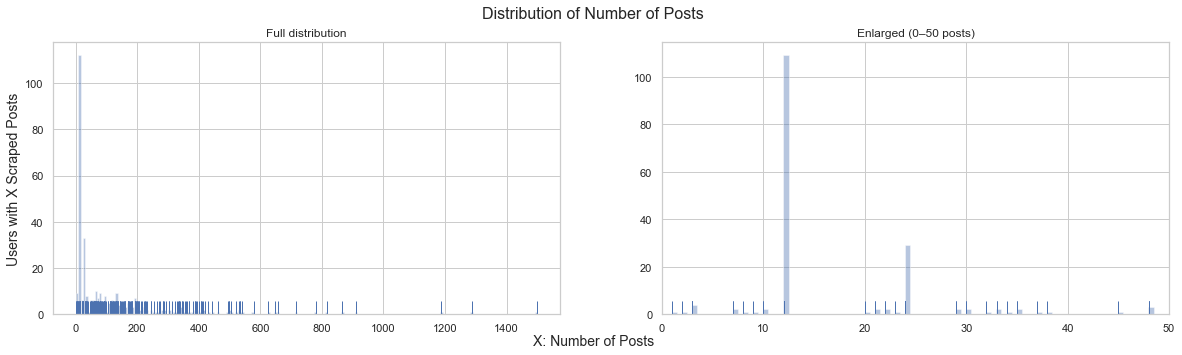

In [9]:
df_dist = df.groupby(['username']).count()[['postsCount']]
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.distplot(df_dist, ax=axes[0], bins=200, kde=False, rug=True)
sns.distplot(df_dist, ax=axes[1], bins=3000, kde=False, rug=True)
axes[0].set_ylabel("Users with X Scraped Posts", size=14)
axes[0].set_title("Full distribution")
axes[1].set_xlim(0, 50)
axes[1].set_title("Enlarged (0–50 posts)")
fig.suptitle('Distribution of Number of Posts', size=16)
fig.text(0.5, 0.04, 'X: Number of Posts', ha='center', size=14)
plt.savefig('assets/num_posts_dist_pre.svg', format='svg')
plt.show()

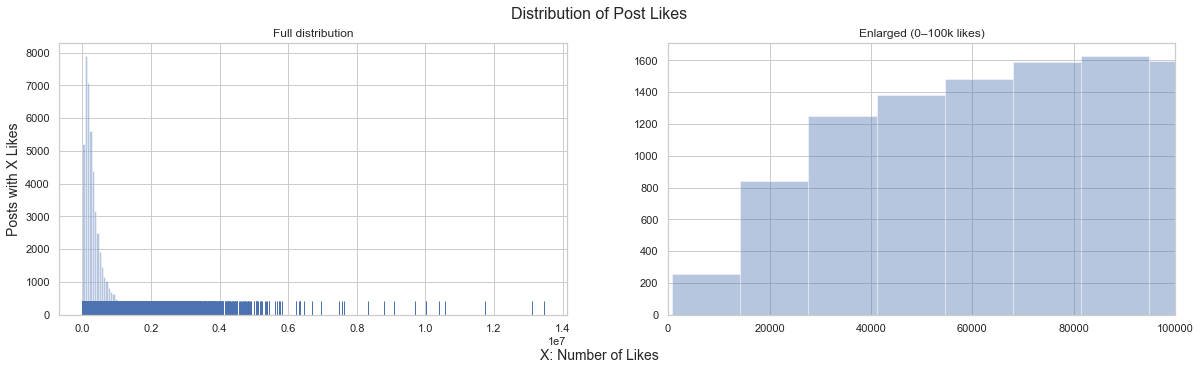

In [10]:
df_dist = df[['likesCount']]
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.distplot(df_dist, ax=axes[0], bins=200, kde=False, rug=True)
sns.distplot(df_dist, ax=axes[1], bins=1000, kde=False)
axes[0].set_ylabel("Posts with X Likes", size=14)
axes[0].set_title("Full distribution")
axes[1].set_title("Enlarged (0–100k likes)")
axes[1].set_xlim(0, 1e5)
fig.suptitle('Distribution of Post Likes', size=16)
fig.text(0.5, 0, 'X: Number of Likes', ha='center', size=14)
plt.savefig('assets/likes_dist_pre.svg', format='svg')
plt.show()

We see, from the distributions, that there are posts whose like counts are abnormally low or high. We want to remove these, as they are likely outliers dependent on factors our prediction model cannot account for and would, therefore, skew our results.

In [11]:
df = df[df['likesCount'].between(df['likesCount'].quantile(0.005), df['likesCount'].quantile(0.995))]

We now have 47259 posts from 355 users. Let's double-check the distribution.

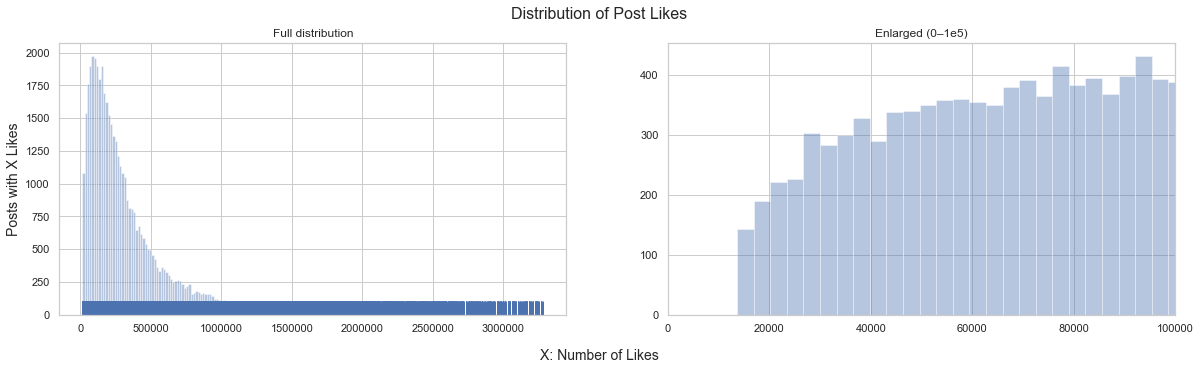

In [12]:
df_dist = df[['likesCount']]
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.distplot(df_dist, ax=axes[0], bins=200, kde=False, rug=True)
sns.distplot(df_dist, ax=axes[1], bins=1000, kde=False)
axes[0].set_ylabel("Posts with X Likes", size=14)
axes[0].set_title("Full distribution")
axes[1].set_title("Enlarged (0–1e5)")
axes[1].set_xlim(0, 1e5)
fig.suptitle('Distribution of Post Likes', size=16)
fig.text(0.5, 0, 'X: Number of Likes', ha='center', size=14)
plt.savefig('assets/likes_dist_post.svg', format='svg')
plt.show()

Better. Now, let's remove users with abnormally low or high numbers of scraped posts to ensure a more even distribution. Low numbers of scraped posts are occasionally the result of scraping problems. Rather than addressing these issues case-by-case, we'll simply drop users with too few (and too many) posts. Why this is necessary will become clear later.

In [13]:
df_dist = df.groupby(['username']).count()[['postsCount']] # group by scraped posts count
df_dist = df_dist.loc[(10 < df_dist['postsCount']) & (df_dist['postsCount'] < 1000)] # filter by number of posts
usernames = df_dist.index.tolist() # retrieve users with number of scraped posts in acceptable range
valid_users = df['username'].map(lambda x: x in usernames) # create filter condition
df = df[valid_users] # filter original dataframe

Again, let's double-check our distribution. We now have 43167 posts from 334 users.

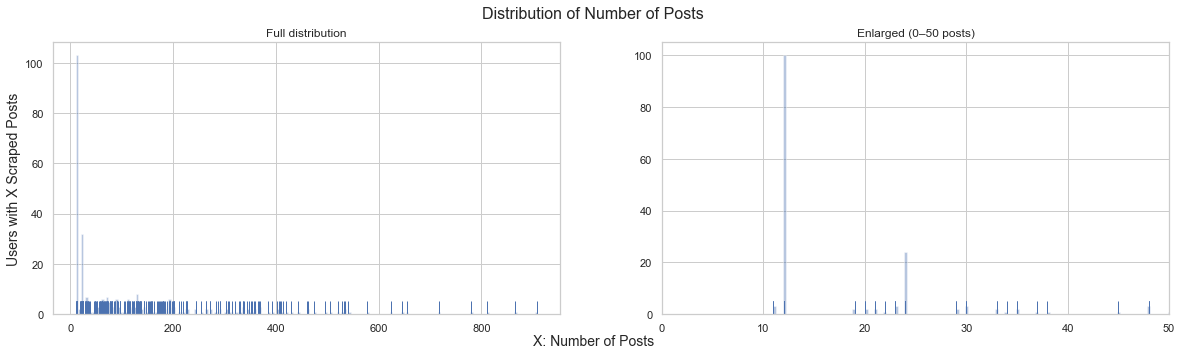

In [14]:
df_dist = df.groupby(['username']).count()[['postsCount']]
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.distplot(df_dist, ax=axes[0], bins=200, kde=False, rug=True)
sns.distplot(df_dist, ax=axes[1], bins=3000, kde=False, rug=True)
axes[0].set_ylabel("Users with X Scraped Posts", size=14)
axes[0].set_title("Full distribution")
axes[1].set_xlim(0, 50)
axes[1].set_title("Enlarged (0–50 posts)")
fig.suptitle('Distribution of Number of Posts', size=16)
fig.text(0.5, 0.04, 'X: Number of Posts', ha='center', size=14)
plt.savefig('assets/num_posts_dist_post.svg', format='svg')
plt.show()

Great. The next step is visualizing trends within individual users. This is key to accounting for potential biases before adding features. To do this, we will examine 10 users that demonstrate the possible trends for users.

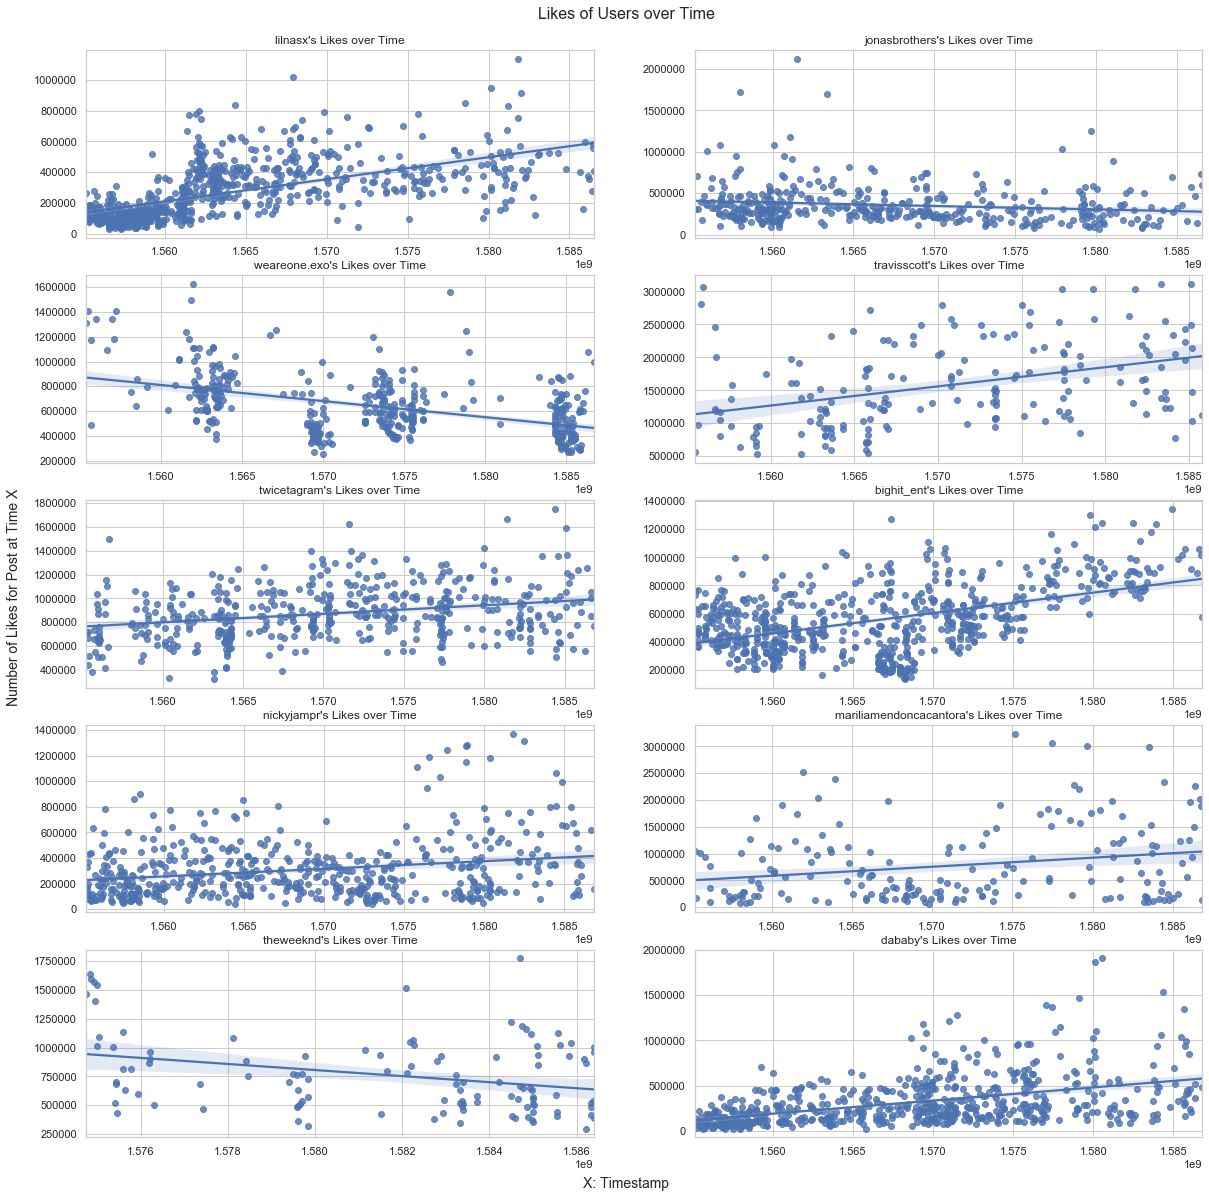

In [15]:
df['normalizedTimestamp'] = df['timestamp'].map(lambda x: x.to_pydatetime().timestamp()) # datetime timestamp column
artists = np.array(['lilnasx', # users chosen because of their trends
                    'jonasbrothers',
                    'weareone.exo',
                    'travisscott',
                    'twicetagram',
                    'bighit_ent',
                    'nickyjampr',
                    'mariliamendoncacantora',
                    'theweeknd',
                    'dababy']).reshape((5, 2))
fig, axes = plt.subplots(5, 2, figsize=(20, 20))
for i in range(5): # plot likes of posts over time for each artist
    for j in range(2):
        artist = artists[i][j]
        df_artist = df[df['username']==artist][['normalizedTimestamp', 'likesCount']]
        sns.regplot(x='normalizedTimestamp', y='likesCount', data=df_artist, ax=axes[i][j])
        axes[i][j].set_title("{}'s Likes over Time".format(artist))
        axes[i][j].set_xlabel("")
        axes[i][j].set_ylabel("")
fig.text(0.5, 0.09, "X: Timestamp", ha='center', size=14)
fig.text(0.07, 0.5, "Number of Likes for Post at Time X", rotation='vertical', va='center', size=14)
fig.suptitle("Likes of Users over Time", y=0.91, size=16)
plt.savefig('assets/user_trends.svg', format='svg')
plt.show()

Examining trends in individual users, we see that there are reasons beyond just the properties of posts that affect number of likes. Assuming the content of posts is independent of time (composition of posts is somewhat constant over time), there are a few possible explanations for this larger trend:

- posts receive fewer likes during times when the user is posting with higher frequency (lilnasx, weareone.exo, dababy)
- users with irregular posting habits receive fewer likes as time increases (weareone.exo, theweeknd)
- changes in popularity of the artist over time affects the number of likes on their posts (lilnasx, jonasbrothers, travisscott, twicetagram, nickyjampr, mariliamendoncacantora, dababy)

We want to consider the influences of these trends before training our model. To do this, let's add a column containing the predicted number of likes at the post's timestamp. For a single post, this is given by

$$
predictedLikes = m\cdot(normalizedTimestamp) + b
$$

where *m* and *b* are the slope and constant, respectively, obtained from running linear regression on the normalizedTimestamp vs. likesCount data of the user. In this step, we make the huge assumption that there always exists a generally linear trend between time and the numbers of likes a user receives on their posts.

Also, to visualize the effect of different features on likesCount in a standardized manner, we will use the following metric

$$
\frac{likesCount}{predictedLikes}
$$

In [16]:
regressions = {}
for username in df['username'].unique().tolist(): # calculate regression for each artist
    df_artist = df[df['username'] == username]
    X = df_artist['normalizedTimestamp'].to_numpy().reshape(-1, 1)
    y = df_artist['likesCount'].to_numpy()
    regr = LinearRegression().fit(X, y)
    regressions[username] = regr
for idx, row in df.iterrows(): # append normalized likes to each post
    username = row['username']
    likes = row['likesCount']
    timestamp = row['normalizedTimestamp']
    prediction = regressions[username].predict([[timestamp]])[0]
    df.at[idx, 'predictedLikes'] = prediction
    df.at[idx, 'normalizedLikesCount'] = likes / prediction

Now that we've performed the essential checks regarding our data, let's handle a few more issues before moving onto feature analysis.

The next subset of posts to drop are ones from users who aren't verified. We do this because we found that only a small percentage of users in our dataset are unverified, so we trade off some data for consistency. Below is the justification.

In [17]:
df_ver = df[df['verified'] == False] # record unverified counts
unverified_posts = df_ver.shape[0]
unverified_users = df_ver['username'].unique().shape[0]
total_posts = df.shape[0] # record total counts
total_users = df['username'].unique().shape[0]
r1 = unverified_posts / total_posts * 100 # calculate posts ratios
r2 = unverified_users / total_users * 100 # calculate users ratios
print("Only %{r1:.2f} of all posts from %{r2:.2f} of all users are from non-verified accounts.".format(r1=r1, r2=r2))

Only %2.32 of all posts from %3.29 of all users are from non-verified accounts.


And now, let's proceed to drop those rows. We are left with 42165 posts from 323 users.

In [18]:
df = df[df['verified'] == True]

## Features
Here, we add features that we will train our prediction model on. We also provide justifications for the features we select.

To start off, we need a caption length column, as we believe caption length may potentially influence a post's number of likes. This column will hold the number of characters in each post's caption (0 if no caption).

In [19]:
df['captionLength'] = df['firstComment'].map(lambda x: 0 if x == None else len(x))

Now, we want to add a column containing the average number of likes for a post's

In [20]:
df_avglc = df[['likesCount', 'username']].groupby('username').mean().rename(columns={'likesCount': 'avgLikesCount'})
df = df.join(df_avglc, on='username')

Next we add three sets of indicator columns, one for the post's time of day, another for the day of the week on which the post was made, and a third for the month during which the post was made.

In [21]:
# time-of-day
df['tod'] = df['timestamp'].map(
    lambda x: 'early' if 0 <= x.hour < 3 else
              'dawn' if 3 <= x.hour < 6 else
              'sunrise' if 6 <= x.hour < 9 else
              'morning' if 9 <= x.hour < 12 else
              'noon' if 12 <= x.hour < 15 else
              'afternoon' if 15 <= x.hour < 18 else
              'sunset' if 18 <= x.hour < 21 else
              'night')
df['early'] = df['timestamp'].map(lambda x: 0 <= x.hour < 3) # for training
df['dawn'] = df['timestamp'].map(lambda x: 3 <= x.hour < 6)
df['sunrise'] = df['timestamp'].map(lambda x: 6 <= x.hour < 9)
df['morning'] = df['timestamp'].map(lambda x: 9 <= x.hour < 12)
df['noon'] = df['timestamp'].map(lambda x: 12 <= x.hour < 15)
df['afternoon'] = df['timestamp'].map(lambda x: 15 <= x.hour < 18)
df['sunset'] = df['timestamp'].map(lambda x: 18 <= x.hour < 21)
# day-of-week
df['dow'] = df['timestamp'].map( # for visualization
    lambda x: 'sunday' if x.day_name() == 'Sunday' else
              'monday' if x.day_name() == 'Monday' else
              'tuesday' if x.day_name() == 'Tuesday' else
              'wednesday' if x.day_name() == 'Wednesday' else
              'thursday' if x.day_name() == 'Thursday' else
              'friday' if x.day_name() == 'Friday' else
              'saturday')
df['sunday'] = df['timestamp'].map(lambda x: x.day_name() == 'Sunday') # for training
df['monday'] = df['timestamp'].map(lambda x: x.day_name() == 'Monday')
df['tuesday'] = df['timestamp'].map(lambda x: x.day_name() == 'Tuesday')
df['wednesday'] = df['timestamp'].map(lambda x: x.day_name() == 'Wednesday')
df['thursday'] = df['timestamp'].map(lambda x: x.day_name() == 'Thursday')
df['friday'] = df['timestamp'].map(lambda x: x.day_name() == 'Friday')
# month-of-year
df['moy'] = df['timestamp'].map( # for visualization
    lambda x: 'january' if x.month == 1 else
              'february' if x.month == 2 else
              'march' if x.month == 3 else
              'april' if x.month == 4 else
              'may' if x.month == 5 else
              'june' if x.month == 6 else
              'july' if x.month == 7 else
              'august' if x.month == 8 else
              'september' if x.month == 9 else
              'october' if x.month == 10 else
              'november' if x.month == 11 else
              'december')
df['january'] = df['timestamp'].map(lambda x: x.month == 'January') # for training
df['february'] = df['timestamp'].map(lambda x: x.month == 'Febraury')
df['march'] = df['timestamp'].map(lambda x: x.month == 'March')
df['april'] = df['timestamp'].map(lambda x: x.month == 'April')
df['may'] = df['timestamp'].map(lambda x: x.month == 'May')
df['june'] = df['timestamp'].map(lambda x: x.month == 'June')
df['july'] = df['timestamp'].map(lambda x: x.month == 'July')
df['august'] = df['timestamp'].map(lambda x: x.month == 'August')
df['september'] = df['timestamp'].map(lambda x: x.month == 'September')
df['october'] = df['timestamp'].map(lambda x: x.month == 'October')
df['november'] = df['timestamp'].map(lambda x: x.month == 'November')

Let's proceed to do some analysis on existing features and show which variables might be worth considering in the machine learning phase.

### Followers Count

We believe that following size may be a factor in determining the number of likes a post will receive. Here, we discover that the average likes-followers ratio decreases in an exponential fashion as following size increases. This suggests that our prediction model may partially be a poly-exponential function of the number of followers (note the logx=True parameter when fitting with seaborn's regplot).

In [22]:
df_fol = df[['username', 'followersCount', 'likesCount']] # extract relevant columns
df_fol['likesFollowersRatio'] = df['likesCount'] / df['followersCount'] # column containing likes-followers ratio
df_fol = df_fol.groupby('username').mean() # average likes & ratio for users (note: followersCount does not change)
df_fol.head(3) # print out df_avgs

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,followersCount,likesCount,likesFollowersRatio
username,,,
21savage,10886991.0,935330.583333,0.085913
5sos,8129347.0,228757.916667,0.028140
7_luhan_m,11808136.0,819635.238095,0.069413


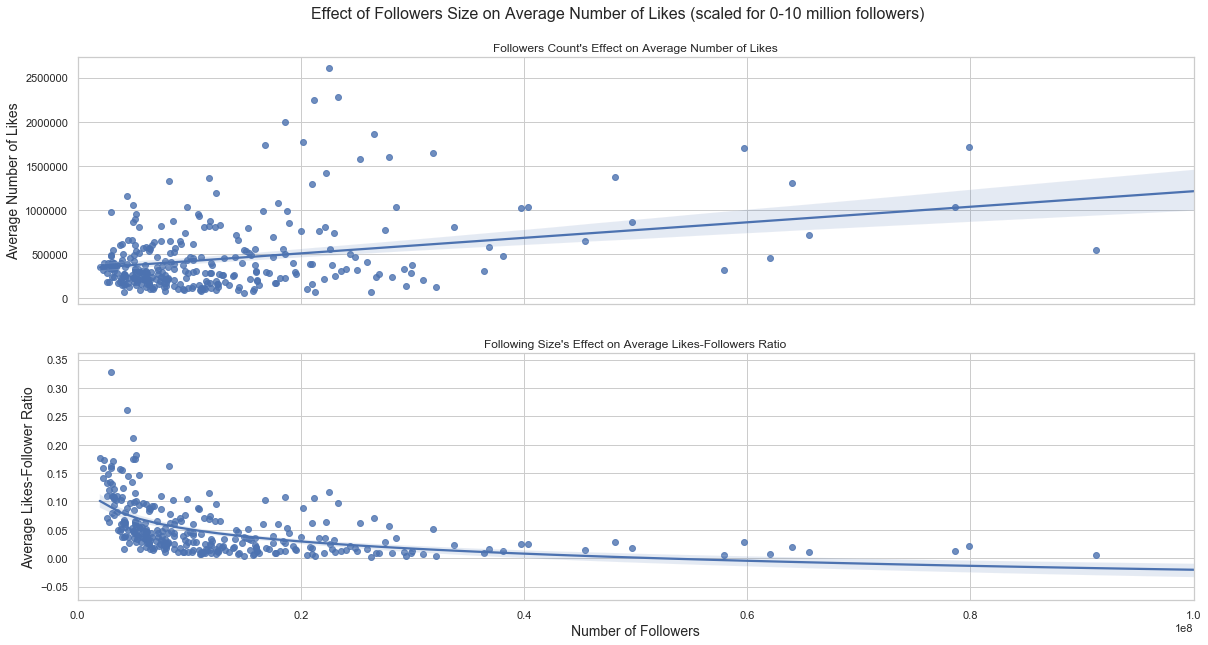

In [23]:
# create two plots showing the effect of followers count on likes count
fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
sns.regplot(x=df_fol['followersCount'], y=df_fol['likesCount'], ax=axes[0])
sns.regplot(x=df_fol['followersCount'], y=df_fol['likesFollowersRatio'], ax=axes[1], logx=True)
axes[0].set_title('Followers Count\'s Effect on Average Number of Likes')
axes[0].set_xlabel('')
axes[0].set_ylabel('Average Number of Likes', size=14)
axes[1].set_xlim(0, 1e8)
axes[1].set_title('Following Size\'s Effect on Average Likes-Followers Ratio')
axes[1].set_ylabel('Average Likes-Follower Ratio', size=14)
plt.xlabel('Number of Followers', size=14)
fig.suptitle('Effect of Followers Size on Average Number of Likes (scaled for 0-10 million followers)', y=0.95, fontsize=16)
plt.savefig('assets/follower_feature.svg', format='svg')
plt.show()

Let's double check this relationship by visualizing the relationship on the logarithm of the data. We should expect a negative slope.

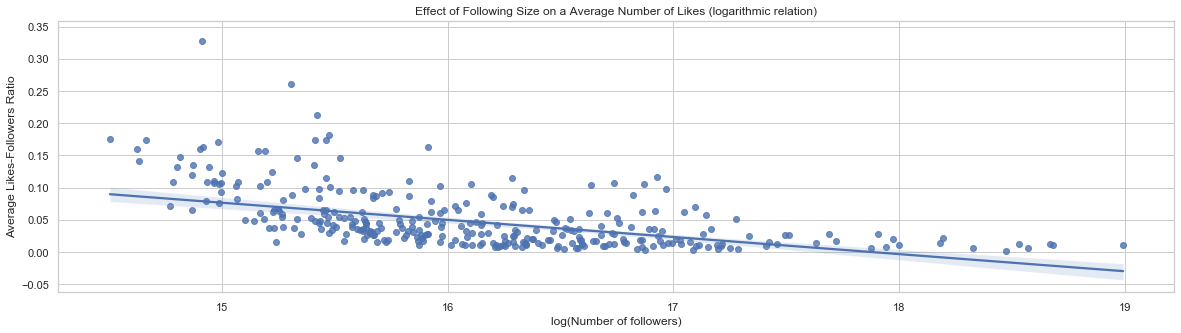

In [24]:
# show the same two graphs at a smaller scale
plt.figure(figsize=(20, 5))
sns.regplot(x=df_fol['followersCount'].map(np.log), y=df_fol['likesFollowersRatio'], robust=True)
plt.title('Effect of Following Size on a Average Number of Likes (logarithmic relation)')
plt.xlabel('log(Number of followers)')
plt.ylabel('Average Likes-Followers Ratio')
plt.savefig('assets/follower_feature_log.svg', format='svg')
plt.show()

There is still some minor curvature in the data, suggesting we may be observing a poly-exponential relation between followers count and the likes-to-followers ratio. This means that the relation between following size and number of likes on posts may also be poly-exponential.

### Caption Length

We believe the length of a post's caption may influence how many likes it receives. In this section, we discovered no strong relation between caption length and likes count for a post, but a slightly negative exponential relation (revealed with Lowess regression) may exist. Unfortunately, there's too much noise in the data to be certain. This suggests that caption length should be considered in the machine learning phase, but it is unlikely to contribute to the prediction task, and we may remove it from our final list of parameters.

In [25]:
df_cap = df[['captionLength', 'normalizedLikesCount',"likesCount"]] # group by caption length
df_cap = df_cap.groupby('captionLength').mean().reset_index()
df_cap.head(3) # print out df_cap

,captionLength,normalizedLikesCount,likesCount
0,0,0.975412,457351.860540
1,1,1.132940,567072.105702
2,2,1.078769,529928.211268


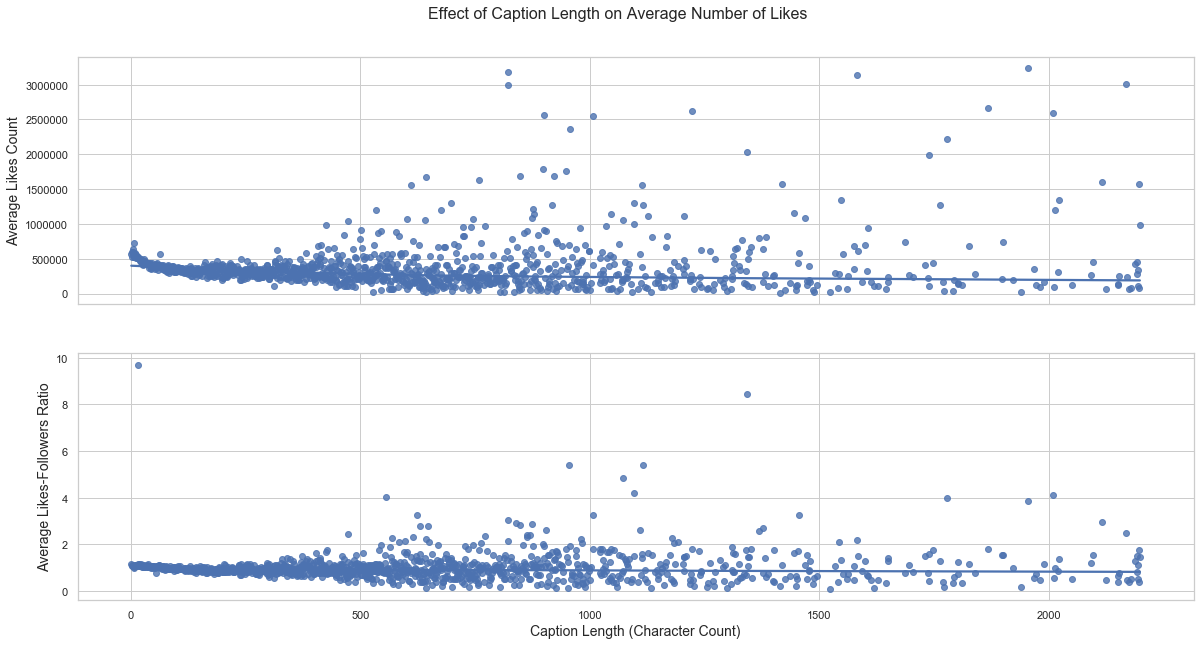

In [26]:
# plot the scatter and show logarithmic relation, note that the first row had to be dropped
fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
sns.regplot(x=df_cap[1:]['captionLength'], y=df_cap[1:]['likesCount'], lowess=True, ax=axes[0])
sns.regplot(x=df_cap[1:]['captionLength'], y=df_cap[1:]['normalizedLikesCount'], lowess=True, ax=axes[1])
axes[0].set_ylabel('Average Likes Count', size=14)
axes[0].set_xlabel('')
axes[1].set_ylabel('Average Likes-Followers Ratio', size = 14)
fig.suptitle("Effect of Caption Length on Average Number of Likes", y=0.95, size=16)
plt.xlabel('Caption Length (Character Count)', size=14)
plt.savefig('assets/caption_feature.svg', format='svg')
plt.show()

Let's double-check this relationship by graphing the logarithmic relationship.

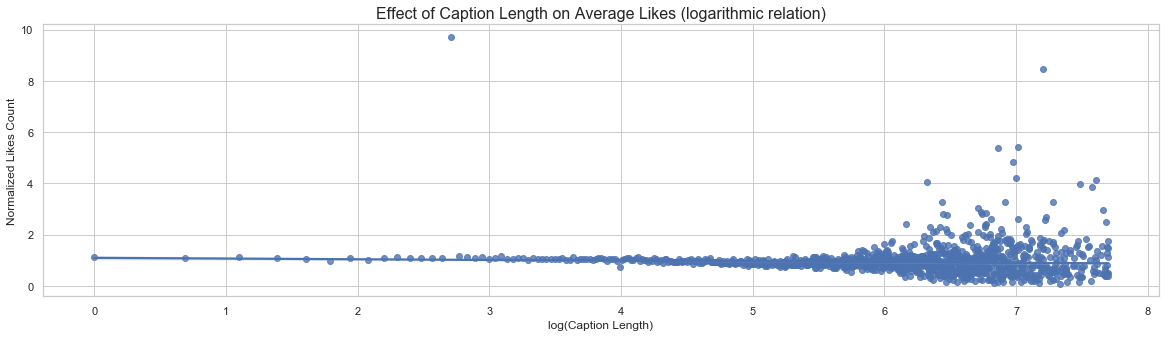

In [27]:
plt.figure(figsize=(20, 5))
sns.regplot(x=df_cap[1:]['captionLength'].map(np.log), y=df_cap[1:]['normalizedLikesCount'], robust=True)
plt.title('Effect of Caption Length on Average Likes (logarithmic relation)', fontsize=16)
plt.xlabel('log(Caption Length)')
plt.ylabel('Normalized Likes Count')
plt.savefig('assets/caption_feature_log.svg', format='svg')
plt.show()

An small negative trend can be observed in this graph, but it is insufficient to make any claims.

### Time-of-Day
We believe that the time-of-day when the post is made may effect the number of likes it receives. In this section, we discovered that certain times (UTC) have higher average normalized likes, but most posts tend to be made during other times. The trends discovered suggest that using a waking/sleeping hour indicator may be a good alternative to dividing the day up into three hours chunks.

In [28]:
todorder = ['early', 'dawn', 'sunrise', 'morning', 'noon', 'afternoon', 'sunset', 'night']
todtimes = ['0:00-2:59', '3:00-5:59', '6:00-8:59', '9:00-11:59', '12:00-14:59', '15:00-17:59', '18:00-20:59', '21:00-23:59']
posts = [df[df['tod'] == tod].shape[0] for tod in todorder]
avg_likes = [df[df['tod'] == tod][['tod', 'likesCount']].groupby('tod').mean()['likesCount'][0] for tod in todorder]

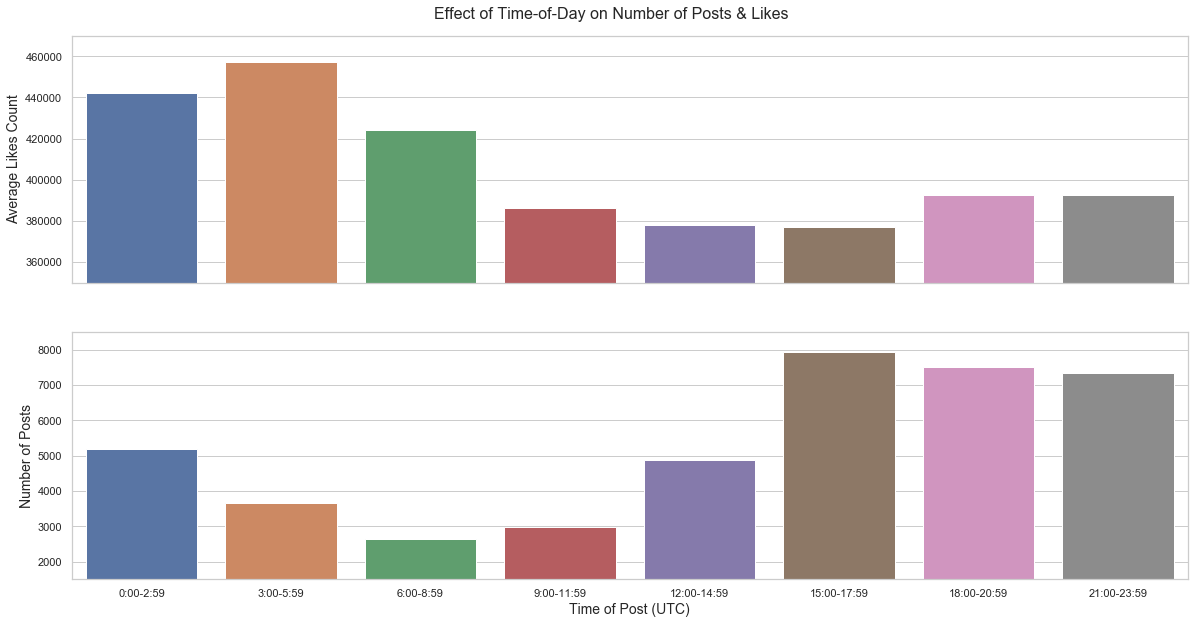

In [29]:
# plot the effect of time of day on number of posts/likes
fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
sns.barplot(x=todorder, y=avg_likes, ax=axes[0])
sns.barplot(x=[tim for tim in todtimes], y=posts, ax=axes[1])
plt.xlabel('Time of Post (UTC)', size=14)
axes[0].set_ylabel('Average Likes Count', size=14)
axes[0].set_ylim(3.5e5, 4.7e5)
axes[1].set_ylabel('Number of Posts', size=14)
axes[1].set_ylim(1500, 8500)
fig.suptitle('Effect of Time-of-Day on Number of Posts & Likes', y=0.92, size=16)
plt.savefig('assets/time_of_day_feature.svg', format='svg')
plt.show()

### Day-of-Week
We believe that the day-of-week when the post was made was may effect the number of likes it receives. In this section, we discovered that the normalized likes value tends to be higher on the weekend, but the number of posts throughout the week remains relatively constant. This suggests that instead of using a day of week indicator, it may be worth using simply a weekday/weekend indicator.

In [30]:
doworder = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
posts = [df[df['dow'] == dow].shape[0] for dow in doworder]
avg_likes = [df[df['dow'] == dow][['dow', 'likesCount']].groupby('dow').mean()['likesCount'][0] for dow in doworder]

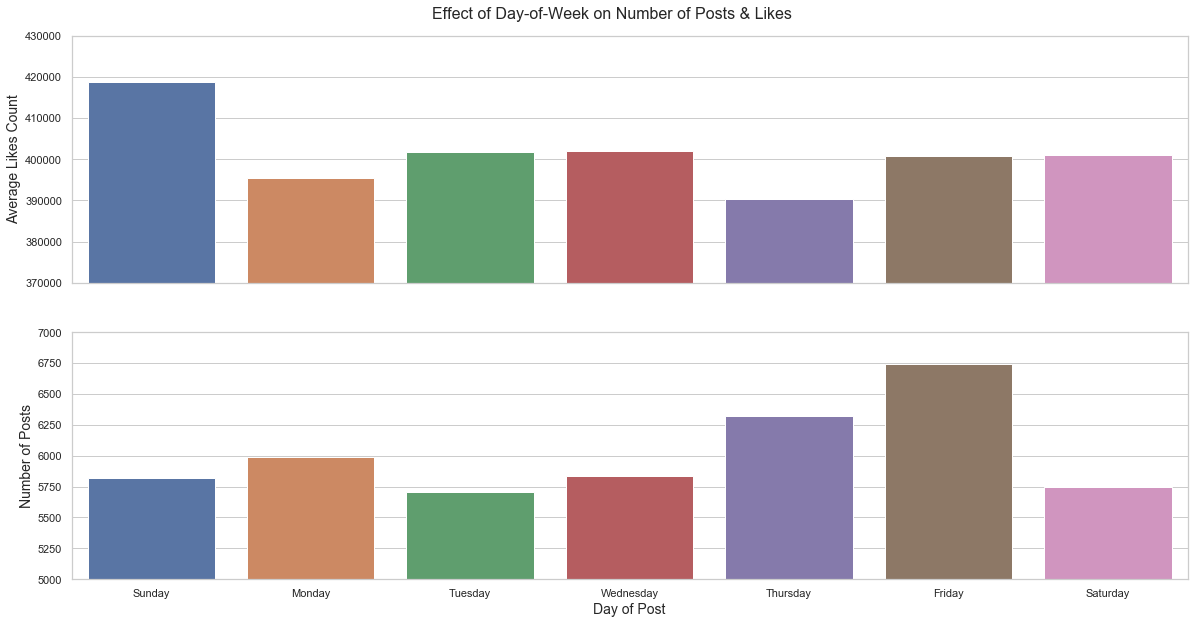

In [31]:
# plot the effect of day of week on the number of posts/likes
fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
sns.barplot(x=doworder, y=avg_likes, ax=axes[0])
sns.barplot(x=[dow.title() for dow in doworder], y=posts, ax=axes[1])
plt.xlabel('Day of Post', size=14)
axes[0].set_ylabel('Average Likes Count', size=14)
axes[0].set_ylim(3.7e5, 4.3e5)
axes[1].set_ylabel('Number of Posts', size=14)
axes[1].set_ylim(5000, 7000)
fig.suptitle('Effect of Day-of-Week on Number of Posts & Likes', y=0.92, size=16)
plt.savefig('assets/day_of_week_feature.svg', format='svg')
plt.show()

### Month-of-Year
We believe that the month in which when the post was made was may effect the number of likes it receives. In this section, we discovered

In [32]:
moyorder = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']
posts = [df[df['moy'] == moy].shape[0] for moy in moyorder]
avg_likes = [df[df['moy'] == moy][['moy', 'likesCount']].groupby('moy').mean()['likesCount'][0] for moy in moyorder]

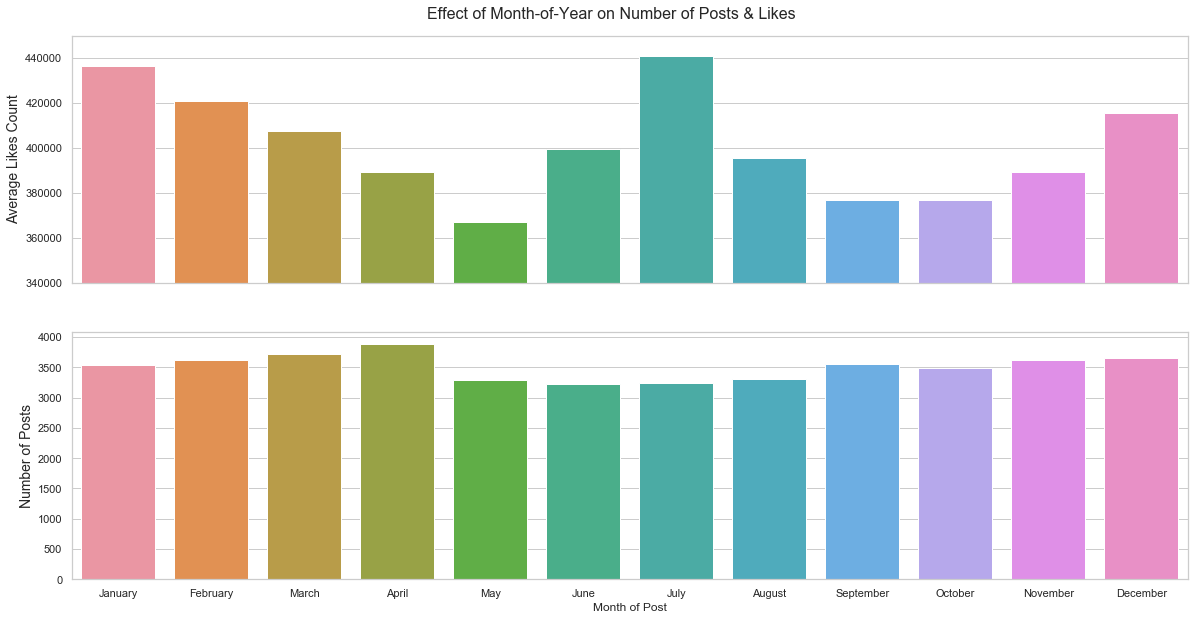

In [33]:
# plot the effect of month of year on the number of posts/likes
fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
sns.barplot(x=moyorder, y=avg_likes, ax=axes[0])
sns.barplot(x=[moy.title() for moy in moyorder], y=posts, ax=axes[1])
plt.xlabel('Month of Post')
axes[0].set_ylabel('Average Likes Count', size=14)
axes[0].set_ylim(3.4e5, 4.5e5)
axes[1].set_xlabel
axes[1].set_ylabel('Number of Posts', size=14)
fig.suptitle('Effect of Month-of-Year on Number of Posts & Likes', y=0.92, size=16)
plt.savefig('assets/month_of_year.svg', format='svg')
plt.show()

### NLP
We believe that the content of a post's caption affects how many likes it will receive. In this section, we use the bag-of-words technique to add NLP features for our machine learning phase.

In [34]:
captions = df['firstComment'].map(lambda x: "" if x is None else x).tolist()
df = df.drop(columns=['timestamp', 'firstComment', 'imageUrl', 'url', 'verified', 'normalizedTimestamp', 'normalizedLikesCount', 'tod', 'dow', 'moy'])
vectorizer = CountVectorizer(stop_words='english', max_features=2000)
X = vectorizer.fit_transform(captions)
feature_array = X.toarray()
df_words = pd.DataFrame(feature_array, columns=vectorizer.get_feature_names())
df = pd.merge(df, df_words, left_index=True, right_index=True)

## Machine Learning
In this section, we train the model and adjust it based on the results summaries.

### Baseline Model
The baseline model predicts, for each post, the average number of likes across all posts in the dataset. We expect the R-squared score to be 0, and the MSE to be higher than that of our trained model.

In [35]:
y = df[['likesCount']]
avg = df['likesCount'].mean()
_, _, _, y_test = train_test_split(df, y, test_size=0.20)
predictions = [(avg,) for _ in range(len(y_test))]
print("Baseline rMSE: ", np.sqrt(mean_squared_error(y_test, predictions)))
print("Baseline R-Squared: ", r2_score(y_test, predictions))

Baseline rMSE:  456315.58887674136
Baseline R-Squared:  -0.0002418496536868986


### Prediction Models
Our prediction model trains on the pre-processed data. We expect the R-squared square to be significantly higher and the MSE to be significantly lower than that of our baseline model. Let's begin by splitting our data into a test set and a train set.

In [36]:
def my_train_test_split(df_tts, test_size):
    X_train, X_test = pd.DataFrame(columns = df_tts.columns), pd.DataFrame(columns = df_tts.columns)
    y_train, y_test = pd.Series(), pd.Series()
    artists = df_tts['username'].unique()
    for artist in artists:
        df_artist = df_tts[df_tts['username']==artist]
        Xa = df_artist[list(df_tts.columns)]
        ya = df_artist['likesCount']
        Xa_train, Xa_test, ya_train, ya_test = train_test_split(Xa, ya, test_size=test_size)
        X_train = X_train.append(Xa_train, ignore_index = True)
        X_test = X_test.append(Xa_test, ignore_index = True)
        y_train = y_train.append(ya_train, ignore_index = True)
        y_test = y_test.append(ya_test, ignore_index = True)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = my_train_test_split(df, test_size=0.20)
X_train, X_test = X_train.drop(columns=['username', 'likesCount']), X_test.drop(columns=['username', 'likesCount'])

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


#### Full Regression (avgLikesCount)
This model uses all features, with the main indicator being avgLikesCount rather than predictedLikes.

In [52]:
regr = Ridge().fit(X_train.drop(columns = 'predictedLikes'), y_train)
predictions = regr.predict(X_test.drop(columns = 'predictedLikes'))
print("MSE (avgLikesCount)", np.sqrt(mean_squared_error(y_test, predictions)))
print("R-Squared (avgLikesCount): ", r2_score(y_test, predictions))

/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.89379e-20): result may not be accurate.
  overwrite_a=True).T


MSE (avgLikesCount) 303684.974478229
R-Squared (avgLikesCount):  0.589973091007371


#### Full Regression (predictedLikes)
This model uses all features, with the main indicator being predictedLikes rather than avgLikesCount.

In [53]:
regr = Ridge().fit(X_train.drop(columns = 'avgLikesCount'), y_train)
predictions = regr.predict(X_test.drop(columns ='avgLikesCount'))
print("MSE (predictedLikes): ", np.sqrt(mean_squared_error(y_test, predictions)))
print("R-Squared (predictedLikes): ", r2_score(y_test, predictions))

/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.89377e-20): result may not be accurate.
  overwrite_a=True).T


MSE (predictedLikes):  295584.9547262634
R-Squared (predictedLikes):  0.6115542275992827


#### Full Regression w/o NLP (avgLikesCount)
This model uses all features, with the main indicator being avgLikesCount and excluding NLP.

In [54]:
regr = Ridge().fit(X_train[list(X_train.drop(columns='predictedLikes').columns[:29]) + ['avgLikesCount']], y_train)
predictions = regr.predict(X_test[list(X_test.drop(columns='predictedLikes').columns[:29]) + ['avgLikesCount']])
print("MSE (avgLikesCount, no NLP) ", np.sqrt(mean_squared_error(y_test, predictions)))
print("R-Squared (avgLikesCount, no NLP): ", r2_score(y_test, predictions))

MSE (avgLikesCount, no NLP)  294544.64976490336
R-Squared (avgLikesCount, no NLP):  0.6142836692943869


/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.80446e-20): result may not be accurate.
  overwrite_a=True).T


#### avgLikesCount Regression
This model uses only the predictedLikes feature.

In [55]:
regr = Ridge().fit(X_train[['avgLikesCount']], y_train)
predictions = regr.predict(X_test[['avgLikesCount']])
print("MSE (avgLikesCount only): ", np.sqrt(mean_squared_error(y_test, predictions)))
print("R-Squared (avgLikesCount only): ", r2_score(y_test, predictions))

MSE (avgLikesCount only):  294751.0704837621
R-Squared (avgLikesCount only):  0.6137428498184023


#### Full Regression w/o NLP (predictedLikes)
This model uses all features, with the main indicator being predictedLikes and excluding NLP.

In [56]:
regr = Ridge().fit(X_train[X_train.drop(columns='avgLikesCount').columns[:30]], y_train)
predictions = regr.predict(X_test[X_test.drop(columns='avgLikesCount').columns[:30]])
print("MSE (predictedLikes, no NLP): ", np.sqrt(mean_squared_error(y_test, predictions)))
print("R-Squared (predictedLikes, no NLP): ", r2_score(y_test, predictions))

MSE (predictedLikes, no NLP):  285517.2332898952
R-Squared (predictedLikes, no NLP):  0.6375647725386326


/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.89377e-20): result may not be accurate.
  overwrite_a=True).T


#### predictedLikes Regression
This model uses only the predictedLikes feature.

In [57]:
regr = Ridge().fit(X_train[['predictedLikes']], y_train)
predictions = regr.predict(X_test[['predictedLikes']])
print("MSE (predictedLikes only): ", np.sqrt(mean_squared_error(y_test, predictions)))
print("R-Squared (predictedLikes only): ", r2_score(y_test, predictions))

MSE (predictedLikes only):  285716.35955895804
R-Squared (predictedLikes only):  0.6370590549647617
